In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
import numpy as np
print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

CUDA: False


device(type='cpu')

# CW_09_part2: Describing an Unknown Optical System

In this task, you are provided with an **unknown optical system** that takes an input of shape `(32, 32)` and outputs a complex field of the same shape `(32, 32)`. The goal is to describe this system mathematically using a **matrix representation**: `Y = M * X`, where:

- `X` is the input vectorized into a `(32*32,)` shape.
- `Y` is the output vectorized into a `(32*32,)` shape.
- `M` is the system matrix with shape `(32*32, 32*32)`.

## Steps to Find the System Matrix `M`

1. **Probe the Optical System**:
   - Probe the system with different input vectors `X_i`. Each vector `X_i`has only one pixel turned on.
   - Probe the system with all `32 * 32 = 1024` different `X_i`.
2. **Construct Input and Output Matrices**:
   - Flatten the output of `optical_system(X)`into a vector with shape `(32 * 32, )`.
3. **Calculate the System Matrix `M`**:
   - Put those outputs into the columns of the matrix `M` which has the shape `(32 * 32, 32 * 32)`.

# Tasks
1. Find the system matrix `M`.
2. Apply the inverse of `M` to obtain the input which produced `CW_09_unknown.npy`.

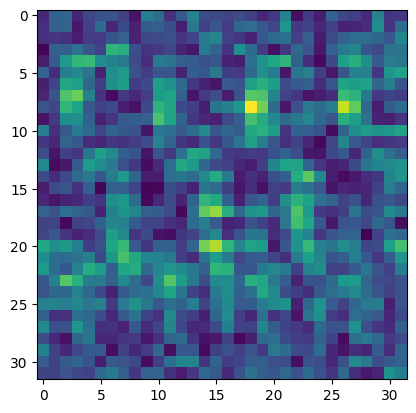

In [26]:
diffuser = torch.tensor(np.load("CW_09_diffusor.npy"))
def optical_system(x):
    ft = lambda x: torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(x)))

    return ft(ft(x) * diffuser)


unknown = torch.tensor(np.load("CW_09_unknown.npy"))
N = unknown.shape[0]
plt.imshow(torch.abs(unknown)) 

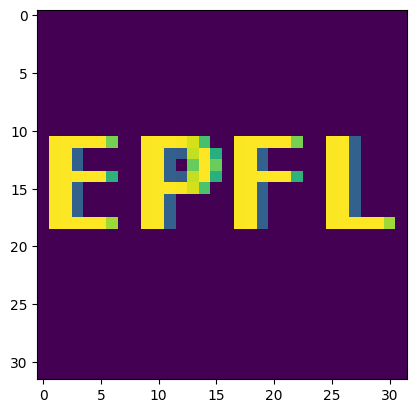

In [27]:
def build_matrix2(N=32):
    M = torch.zeros(N * N, N * N) + 0j

    # probe optical system
    m = 0
    for i in range(N):
        for j in range(N):
            X = torch.zeros((N, N))
            X[i, j] = 1
            M[:, m] = optical_system(X).reshape(N * N)
            m += 1
        
    return M

M2 = build_matrix2()
known2 = (torch.inverse(M2) @ unknown.reshape(N * N)).reshape(N, N)

plt.imshow(torch.abs(known2))

# CW_09_part2: Describing an Unknown Optical System
# This is another extra way

In this task, you are provided with an **unknown optical system** that takes an input of shape `(32, 32)` and outputs a complex field of the same shape `(32, 32)`. The goal is to describe this system mathematically using a **matrix representation**: `Y = M * X`, where:

- `X` is the input vectorized into a `(32*32,)` shape.
- `Y` is the output vectorized into a `(32*32,)` shape.
- `M` is the system matrix with shape `(32*32, 32*32)`.

## Steps to Find the System Matrix `M`

1. **Probe the Optical System**:
   - Generate **random input phases** `X` of shape `(32, 32)`.
   - Pass these inputs through the optical system to record the corresponding outputs `Y` of shape `(32, 32)`.

2. **Construct Input and Output Matrices**:
   - Flatten each input `X` and output `Y` into vectors of shape `(32*32,)`.
   - Assemble these vectors into matrices:
     - `X_matrix` has shape `(32*32, K)`, where `K` is the number of probe inputs.
     - `Y_matrix` has shape `(32*32, K)`.

3. **Calculate the System Matrix `M`**:
   - Compute the **pseudoinverse** of `X_matrix` using `torch.pinverse(X_matrix, rcond=1e-2)`.
   - Multiply the pseudoinverse of `X_matrix` with `Y_matrix` to obtain `M`:
   - The resulting M will have the shape `(32*32, 32*32)`.



# Tasks
1. Find the system matrix `M`.
2. How many probe inputs do you need? 10, 100, 1000, 10000, ....

In [28]:
def build_matrix(K, N=32):
    # input and outputs
    Xs = torch.zeros(N, N, K) + 0j
    Ys = torch.zeros(N, N, K) + 0j

    # probe optical system
    for i in range(K):
        X = torch.exp(1j * torch.rand(N, N) * 6)
        Xs[:, :, i] = X
        Ys[:, :, i] = optical_system(X)

    # Calculate pseudoinverse of X
    X_pinv = torch.pinverse(Xs.reshape(N * N, K), rcond=1e-2)

    # Solve for M
    M = Ys.reshape(N * N, K) @ X_pinv
    return M

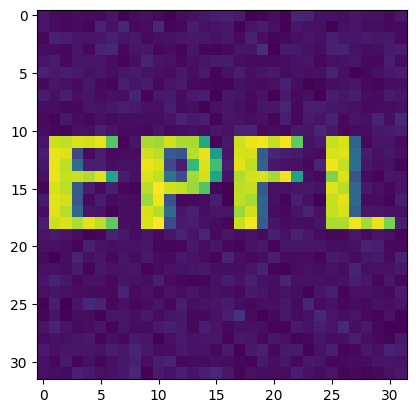

In [33]:
M = build_matrix(1000)
known = (torch.pinverse(M, rcond=1e-2) @ unknown.reshape(N * N)).reshape(N, N)

plt.imshow(torch.abs(known))